In [77]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt 
import numpy as np
import torch.nn.functional as F

## Traditional VAE

In [79]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=2):
        super().__init__()
        
        #encoder layers
        self.enc_fc1 = nn.Linear(input_dim, hidden_dim)
        self.enc_mu = nn.Linear(hidden_dim, latent_dim)
        self.enc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        #decoder layers
        self.dec_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.dec_fc2 = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x):
        h = torch.relu(self.enc_fc1(x))
        mu = self.enc_mu(h)
        logvar = self.enc_logvar(h)
        return mu, logvar
    
    def decode(self, z):
        h = torch.relu(self.dec_fc1(z))
        x_hat = torch.sigmoid(self.dec_fc2(h))
        return x_hat
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        std = torch.exp(0.5*logvar)
        epsilon = torch.randn_like(std)
        z = mu + epsilon*std
        x_hat = self.decode(z)
        return x_hat, mu, logvar
        
    

In [81]:
torch.zeros_like(torch.tensor(3))

tensor(0)

In [83]:
def loss_function(x, x_hat, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = (recon_loss + kld) / x.size(0)
    return loss

In [85]:
input_dim = 784
hidden_dim = 128
latent_dim = 16
lr = 0.01
batch_size = 128
epochs = 10

train_data = datasets.MNIST(
    root='./data', 
    train=True, 
    transform=transforms.ToTensor(), 
    download=True)

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True
)

In [87]:
image, label = train_data[1]

In [89]:
image.shape

torch.Size([1, 28, 28])

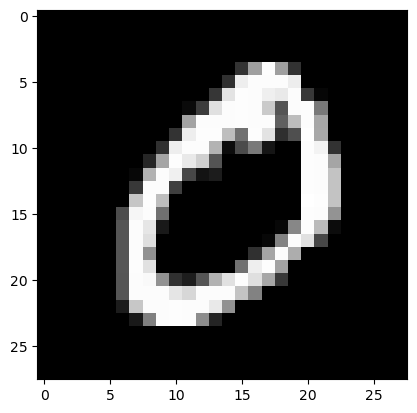

In [91]:
plt.imshow(image.squeeze(), cmap='gray') # squeeze removes the first dimension

In [93]:
vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=lr)

In [11]:
#training 
for epoch in range(epochs):
    train_loss = 0
    for x, _ in train_dataloader:
        x = x.view(-1, 28*28)
        x_hat, mu, logvar = vae(x)
        loss = loss_function(x, x_hat, mu, logvar)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_dataloader.dataset)}")

Epoch 1, Loss: 1.1549253463745117
Epoch 2, Loss: 0.9600387215614319
Epoch 3, Loss: 0.9330597519874573
Epoch 4, Loss: 0.9216527938842773
Epoch 5, Loss: 0.9154216051101685
Epoch 6, Loss: 0.9118248820304871
Epoch 7, Loss: 0.9070477485656738
Epoch 8, Loss: 0.9032031297683716
Epoch 9, Loss: 0.901614785194397
Epoch 10, Loss: 0.8995293974876404


In [12]:
next(iter(train_dataloader))[0].shape

torch.Size([128, 1, 28, 28])

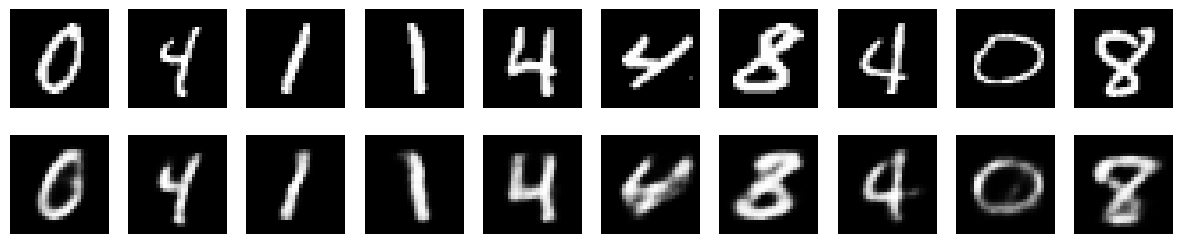

In [13]:
#inference

with torch.no_grad():
    x, _ = next(iter(train_dataloader))
    x = x.view(-1, input_dim)
    x_hat, _, _ = vae(x)
    x = x.view(-1, 28, 28)
    x_hat = x_hat.view(-1, 28, 28)
    
    fig, axs = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axs[0, i].imshow(x[i].numpy(), cmap='gray')
        axs[1, i].imshow(x_hat[i].numpy(), cmap='gray')
        axs[0, i].axis('off')
        axs[1, i].axis('off')
    plt.show()

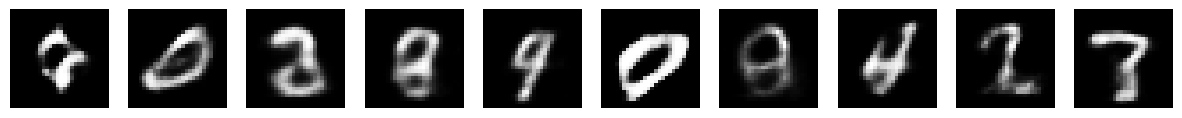

In [14]:
#generated samples
with torch.no_grad():
    z = torch.randn(10, latent_dim)
    sample = vae.decode(z)
    sample = sample.view(-1, 28, 28)
    
    fig, axs = plt.subplots(1, 10, figsize=(15, 3))
    for i in range(10):
        axs[i].imshow(sample[i].numpy(), cmap='gray')
        axs[i].axis('off')
    plt.show()

## M2 VAE